# 优化发电调度


电网为现代生活的几乎每个方面供电 - 无论是为手机充电、为工厂供电,还是挖比特币。
能源部门的决策者必须确保电力供应顺畅充足,满足现代生活日益增长的电力需求。
毕竟权力越大,责任越大。

Nuclear power plants. Source: Daniel Prudek / Shutterstock).


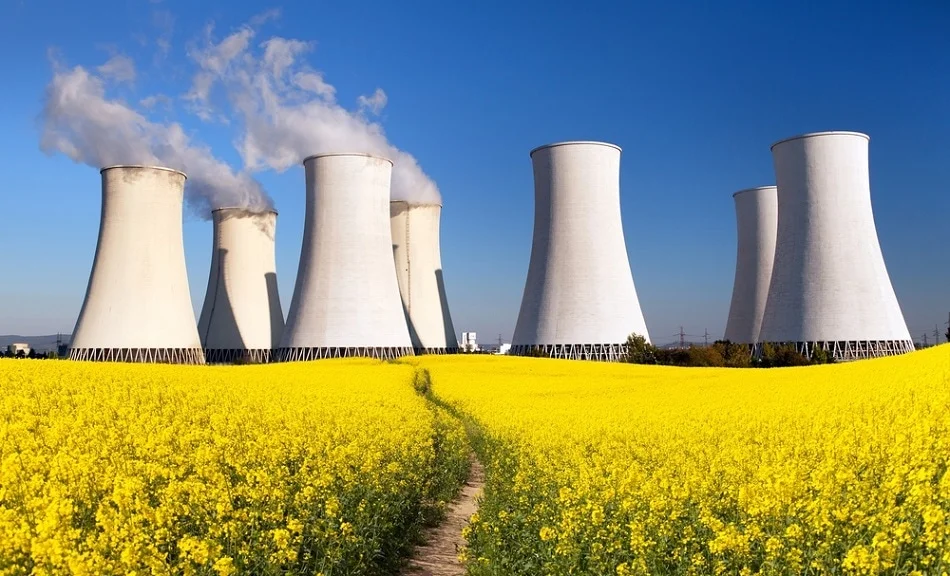

In [1]:
from PIL import Image
import requests
from io import BytesIO
 
print('Nuclear power plants. Source: Daniel Prudek / Shutterstock).')  
img = Image.open(BytesIO(requests.get('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/image_powerplant.png?raw=true').content))
img 
# Image('image_powerplant.png')

管理电力供需可能是一项复杂而具有挑战性的任务。假设我们负责为美国佐治亚州发电。如果我们知道所有可用发电厂的组合以及一天中每小时的电力需求,我们能否制定一个调度计划来决定每个发电厂应该发多少电,以及何时将发电厂"开启"和"关闭"？在最小化总成本的同时,我们该如何做到这一点？

在本笔记本中,我们使用**数学优化**对这个决策问题进行建模。笔记本的第一部分描述了所使用的数据集。我们使用了佐治亚州的真实数据,该州人口为1080万。数据包括历史用电需求以及发电厂的具体信息。

笔记本的第二部分介绍了数学优化模型的三个组成部分:需要优化的目标函数、决策变量和约束条件。在我们的发电问题中,**目标**是最小化总成本。**决策变量**对发电调度进行建模。**约束条件**包括基本要求,如确保电力供应满足需求,以及每个发电厂的最小和最大产能等实际限制。通过找到最优成本效益的调度,该模型帮助发电厂运营商在最小化总成本的同时,从其设施中获得最佳产出。


让我们开始吧。

## 数据

首先,让我们加载处理和可视化数据所需的包。

In [20]:
# %pip install networkx seaborn
import pandas as pd   
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings
warnings.filterwarnings("ignore")

### 历史用电需求数据

首先,读取需求数据。
'demand.csv' 文件包含了2004年至2013年佐治亚州的历史用电需求。
该数据涵盖了夏季月份(7月)和冬季月份(1月)的31天中每小时的用电量。

在本笔记本的其余部分,我们将选择一个日期,例如2011年7月1日。

我们将需求存储为一个字典,以每小时(1到24)为索引,以所需的电量为值。

In [21]:
# df_load_curves = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/demand.csv?raw=true') 
df_load_curves = pd.read_csv('demand.csv')

# 选择指定日期(2011年7月1日)的需求
df_subset = df_load_curves[(df_load_curves['YEAR']==2011)&(df_load_curves['MONTH']==7)&(df_load_curves['DAY']==1)] 

# 将需求存储到字典中
d = df_subset.set_index(['HOUR']).LOAD.to_dict() 

H = set(d.keys()) # 一天中的小时集合(1到24)

我们可以可视化2011年7月1日佐治亚州的用电情况。

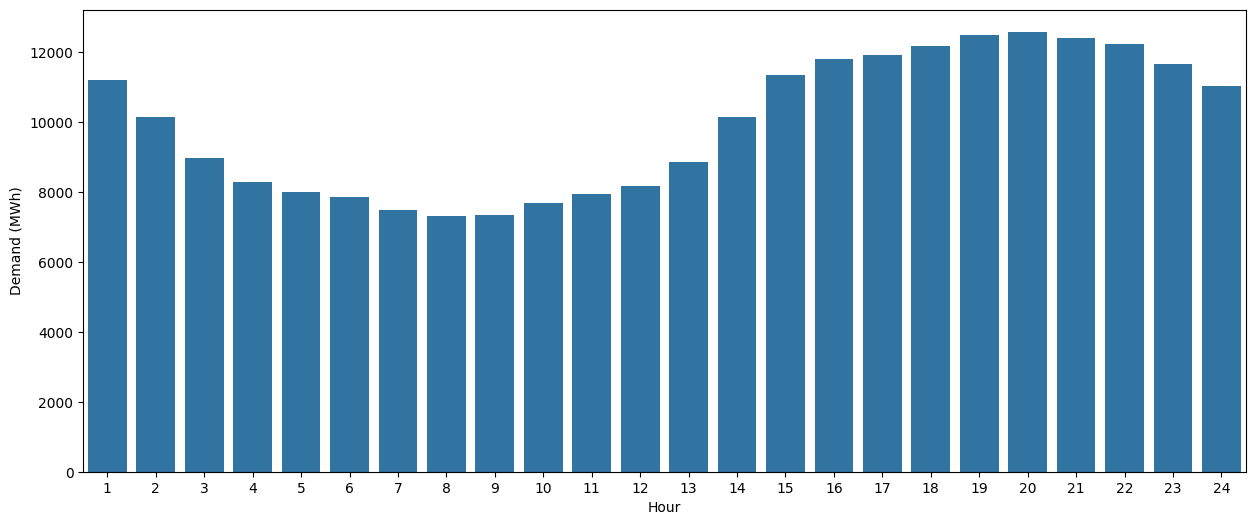

In [22]:
fig, ax = plt.subplots(figsize=(15,6)) 
demand_plot = sns.barplot(x=list(range(1,25)), y=[d[h] for h in range(1,25)])
demand_plot.set_xticklabels(demand_plot.get_xticklabels());
demand_plot.set(xlabel='Hour', ylabel='Demand (MWh)');
plt.show() 

晚上用电量比早上高。

### 发电厂数据

接下来,让我们加载有关发电厂的信息。

真实数据集非常大,包含99个发电厂。使用大数据集解决优化问题需要完整的Gurobi许可证。
如果您是学术界人士(学生或教师),可以在[这里](https://www.gurobi.com/academia/academic-program-and-licenses/)申请免费的Gurobi许可证。
为了在没有许可证的情况下使用Gurobipy包,本笔记本使用了一个简化的小数据集,包含**十组**发电厂。
要使用完整数据测试模型,只需在代码的其余部分将'small_plant_data'替换为'large_plant_data'。

发电厂根据所消耗的燃料类型分为不同类型。
在我们的数据集中,有**六种类型**的发电厂:煤炭、核能、石油、天然气、水电和生物质能。
在本笔记本使用的小数据集中,我们有十个发电厂 - 即两个核电厂(Edwin I Hatch和Vogtle)和三个煤电厂(Bowen、Jack McDonough和Scherer),其余的煤电厂合并为一个名为'OTHER COAL'的超级电厂,以及四组合并的发电厂,分别为'BIOMASS'、'GAS'、'HYDRO'和'OIL'。

每个发电厂使用的**燃料**也从文件中加载。这些信息对于确定一些与燃料相关的成本是必要的。

现在我们加载这些数据。

In [23]:
# df_plant_info = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/plant_capacities.csv?raw=true') # replace "small_plant_data" with "large_plant_data" to use the full dataset
df_plant_info = pd.read_csv('small_plant_data/plant_capacities.csv')

P = set(df_plant_info['Plant'].unique())                          # set of all power plants

plant_type = df_plant_info.set_index('Plant').PlantType.to_dict() # plant type for each plant

P_N = set([i for i in P if plant_type[i]=='NUCLEAR'])             # set of all nuclear plants  

fuel_type = df_plant_info.set_index('Plant').FuelType.to_dict()   # fuel type for each plant


### 发电厂的产能和限制

总体目标是确定每个发电厂的发电量。这个发电量必须在发电厂的最小和最大生产限制(MWh)之内。见下图,了解十个发电厂的最大生产限制。

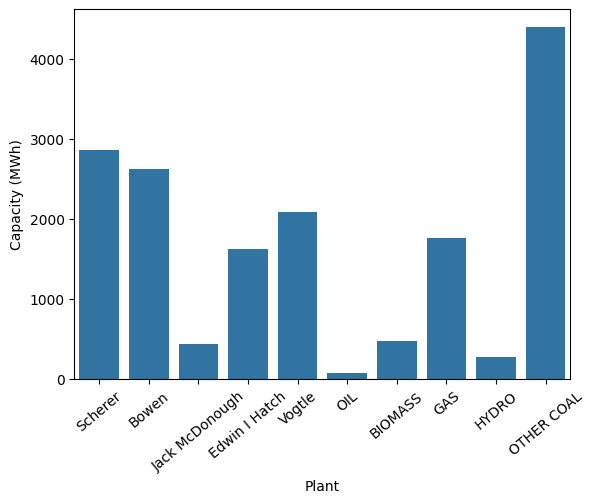

In [24]:
df_plant_info['capacity'] = df_plant_info['Capacity']
c = df_plant_info.set_index('Plant').capacity.to_dict() # generation capacity   

capacity_plot = sns.barplot(x=list(c.keys()), y=[c[k] for k in c])
capacity_plot.set_xticklabels(capacity_plot.get_xticklabels(), rotation=40);
capacity_plot.set(xlabel='Plant', ylabel='Capacity (MWh)');
plt.show() 

显然,煤电厂的生产能力最高,其次是核电厂和水电厂。

此外,如果核电厂被"开启",它必须至少产生其最大产能的80%。对于其他发电厂,我们将此最小限制设置为1%。

In [25]:
m = {i: 0.8 if i in P_N else 0.01 for i in P} # min % generation when on 

此外,我们还对发电调度在连续小时之间的**爬坡**或**降坡**速度进行了限制。
此限制确保发电厂不会被迫对其发电调度进行剧烈变化。

我们将此速度限制设置为核电厂的**20%**和煤电厂的**25%**。换句话说,煤电厂在一小时内的爬坡或降坡速度不能超过其总产能的25%。
我们将此速度限制设置为所有其他发电厂的**100%**,从而不对速度施加限制。

In [26]:
r = {i: 1 if i in ['BIOMASS','GAS','HYDRO','OIL'] else .2 if i in P_N else .25 for i in P}  # ramp up/down speed (plant)  

### 成本

最后,我们加载成本数据。有五种类型的成本:燃料成本、运营成本、启动和关闭成本以及健康成本。
我们有基于燃料类型的历史年度平均数据(2004-2011年)。
在本笔记本的其余部分,我们将使用2011年的平均成本。

首先是**燃料成本**,它衡量生产*一*兆瓦时电力的成本。
如下图所示,煤炭和天然气燃料类型最昂贵,而核能最便宜。

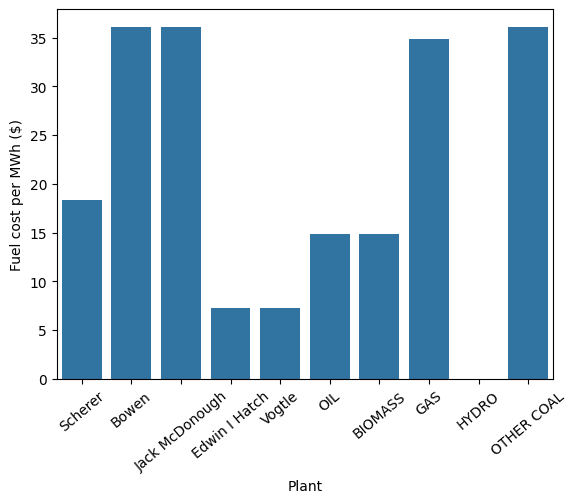

In [27]:
# df_fuel_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/fuel_costs.csv?raw=true') 
df_fuel_costs = pd.read_csv('small_plant_data/fuel_costs.csv') 

# read the fuel costs and transform it from fuel-type to plant-name
f = {i: df_fuel_costs[df_fuel_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # dictionary of fuel cost for each plant

# plot the fuel costs
fuelcost_plot = sns.barplot(x=list(f.keys()), y=[f[k] for k in f])
fuelcost_plot.set_xticklabels(fuelcost_plot.get_xticklabels(), rotation=40);
fuelcost_plot.set(xlabel='Plant', ylabel='Fuel cost per MWh ($)');
plt.show()

第二是**运营成本**,即保持发电厂开启的每小时成本。

In [19]:
# df_oper_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/operating_costs.csv?raw=true')  
df_oper_costs = pd.read_csv('small_plant_data/operating_costs.csv')
o = {i: df_oper_costs[df_oper_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)

第三和第四是**启动**和**关闭成本**,它们在发电厂启动和关闭时产生惩罚。将这些成本纳入模型可确保发电调度的稳定性。

In [30]:
# df_startup_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/startup_costs.csv?raw=true')  
df_startup_costs = pd.read_csv('small_plant_data/startup_costs.csv')
s = {i: df_startup_costs[df_startup_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)
 
t = s.copy() # assume that the cost of shuting down = starting up

最后,我们加载**健康成本**,它们捕捉了燃烧过多煤炭的健康影响。此数据仅适用于三个煤电厂(Bowen、Jack McDonough和Scherer)。


健康成本是根据一天中的时间依赖的各种环境因素汇总的。如下图所示,在Bowen发电厂,健康成本在晚上比早上高得多。

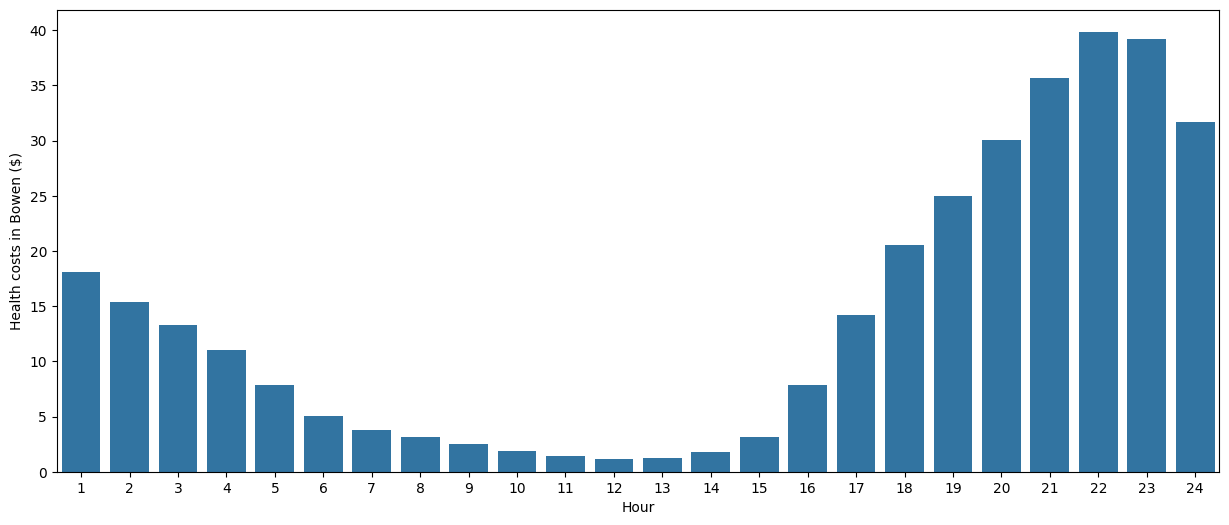

In [43]:
# df_health_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/health_costs.csv?raw=true')  
df_health_costs = pd.read_csv('small_plant_data/health_costs.csv')
a = df_health_costs[(df_health_costs['Year']==2007)&(df_health_costs['Day']==1)].set_index(['Plant','Hour']).to_dict()['Cost'] # operating cost/MWh (plant)
a.update({(i,h): 0 for i in P for h in H if i not in ['Bowen','Jack McDonough','Scherer']})  

fig, ax = plt.subplots(figsize=(15,6)) 
healthcost_plot = sns.barplot(x=list(range(1,25)), y=[a['Bowen',h] for h in range(1,25)])
healthcost_plot.set_xticklabels(healthcost_plot.get_xticklabels());
healthcost_plot.set(xlabel='Hour', ylabel='Health costs in Bowen ($)');
plt.show() 

## 优化模型

我们现在将解决决策问题。
使用这十个发电厂,并了解它们的能力和限制,最具成本效益的发电方式是什么,以完全满足佐治亚州的能源需求？

我们可以在数学优化模型中捕捉这些复杂的考虑因素。
优化模型根据**目标函数**找到**最佳解决方案**,使得解决方案满足一组**约束条件**。
在这里,解决方案表示为一组实数值或整数值,称为**决策变量**。
约束条件是一组以决策变量为函数的方程或不等式。

对于我们的发电问题,目标是最小化总成本。
决策变量表示每个发电厂的发电调度。
发电厂的限制和能力通过约束条件来捕捉。

现在让我们定义模型的输入。下标 $i$ 和 $h$ 将用于表示每个发电厂和小时。

### 输入参数
集合:
- $P\ (P_N)$: (核)发电厂集合,
- $H$: 小时集合。

需求、产能和速度限制:
- $d_h$: 每小时 $h$ 的电力需求,
- $c_i$: 发电厂 $i$ 的最大发电能力,
- $m_i$: 发电厂 $i$ 必须产生的最小%电力,
- $r_i$: 发电厂 $i$ 的爬坡/降坡速度。

成本:
- $f_i, o_i$: 发电厂 $i$ 的燃料和运营成本,
- $a_{ih}$: 发电厂 $i$ 在小时 $h$ 的健康成本,
- $s_i, t_i$: 发电厂 $i$ 的启动和关闭成本。

我们已经加载了这些参数,并将每个输入存储为字典。

以下代码加载Gurobi python包并启动优化模型。

In [47]:
# %pip install gurobipy 
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("powergeneration")

Set parameter LicenseID to value 2601452


启动优化模型后,我们将通过添加变量、目标和约束逐步构建模型。

首先,我们将定义决策变量。
根据可以取值的范围,有几种类型的变量。
**连续**变量可以在下限和上限之间取任何实数值,而**二进制**变量可以是0或1。

我们的关键决策变量是一个连续变量。
设 $z_{i,h}$ 为发电厂 $i$ 在小时 $h$ 产生的电量; 这必须至少为 $0$。

我们可以使用gurobipy的**addVars**函数将此变量添加到模型中。

In [49]:
z = model.addVars(P, H, name="z", lb=0)             # power generated in each plant for each hour 

我们模型中的其余决策变量是二进制变量,这意味着它们充当开/关开关。
设 $u_{i,h}$ 为发电厂 $i$ 在小时 $h$ 是否*开启*的指示符。
此外,设 $v_{i,h}$ 和 $w_{i,h}$ 为发电厂 $i$ 在小时 $h$ 是否*启动*或*关闭*的指示符。
这些变量中的每一个在为真时取值为 $1$,否则为 $0$。

我们现在使用**addVars**函数将这些二进制变量添加到模型中。

In [50]:
u = model.addVars(P, H, name="u", vtype=GRB.BINARY) # is the plant on? for each plant and hour

v = model.addVars(P, H, name="v", vtype=GRB.BINARY) # start up the plant? for each plant and hour

w = model.addVars(P, H, name="w", vtype=GRB.BINARY) # shut down the plant? for each plant and hour 

print("This model has",len(z)+len(u)+len(v)+len(w),"decision variables.")

model.update()  

This model has 960 decision variables.


### 目标: 最小化总成本

定义了变量后,我们现在告诉模型要优化什么。
我们希望最小化由五个组成部分组成的总成本 - 燃料、健康、运营、启动和关闭成本。
我们可以使用决策变量将总成本数学表达为以下内容,

\begin{align*} 
\sum_{\textrm{plant}\ i} \sum_{\textrm{hour}\ h} (f_i z_{i,h} + a_{i,h} z_{i,h} + o_i u_{i,h} + s_i v_{i,h} + t_i w_{i,h})
\end{align*}

我们现在使用**setObjective**函数将此目标函数添加到模型中。
关键输入是所有项的总和。
以下是逐一添加五个组成部分的一种方法。

In [51]:
objective = gp.quicksum(f[i]*z[i,h] for i in P for h in H) # fuel cost
objective += gp.quicksum(a[i,h]*z[i,h] for i in P for h in H) # health cost
objective += gp.quicksum(o[i]*u[i,h] for i in P for h in H) # operating cost
objective += gp.quicksum(s[i]*v[i,h] for i in P for h in H) # startup cost
objective += gp.quicksum(t[i]*w[i,h] for i in P for h in H) # shutdown cost
model.setObjective(objective, sense=GRB.MINIMIZE)

接下来,我们告诉模型决策变量可以取值的范围。这是通过*约束*来完成的。

### 约束: 满足需求

首先,我们要确保每小时所有发电厂产生的总电量等于该小时的电力需求。
此要求可以数学表达为每小时 $h$ 的以下等式约束。

\begin{align*} 
\sum_{\textrm{plant}\ i} z_{i,h} &= d_h
\end{align*}

我们现在使用**addConstrs**函数将此约束添加到模型中。

In [52]:
model.addConstrs((gp.quicksum(z[i,h] for i in P) == d[h]) for h in H)  

model.update()

### 约束: 最大和最小发电水平

我们确保每个发电厂产生的电量不超过发电厂的最大产能(由 $c_i$ 表示)。此约束可以表示为每个发电厂和小时的 $z_{i,h} \leq c_i$ 不等式。
我们还希望确保当发电厂"关闭"时,即 $u_{i,h}=0$ 时,我们不产生任何电量,即 $z_{i,h}=0$。
我们可以通过以下每个发电厂 $i$ 和小时 $h$ 的不等式来捕捉这一点,

\begin{align*} 
z_{i,h} \leq c_i u_{i,h}
\end{align*}

此外,请记住,每个发电厂需要产生一定的最小%电量(由 $m_i$ 表示)。
核电厂必须产生其产能的至少80%,其余发电厂必须产生其产能的至少1%。
这可以通过以下每个发电厂 $i$ 和小时 $h$ 的不等式来表示,

\begin{align*} 
z_{i,h}  \geq m_i c_i u_{i,h}
\end{align*}

请注意,此约束还确保当没有发电时,即 $z_{i,h} = 0$,则发电厂被认为是关闭的,即 $u_{i,h} =0$。

我们现在将这些约束添加到模型中。

In [53]:
model.addConstrs((z[i,h] <= c[i]*u[i,h]) for i in P for h in H)  

model.addConstrs((z[i,h] >= m[i]*c[i]*u[i,h]) for i in P for h in H)  

model.update()  

### 约束: 核电厂始终开启

与其他类型的发电厂不同,核电厂不能在短时间内轻易关闭。
在我们的模型中,我们添加了一个约束,确保核电厂始终"开启"。
这可以通过将 $u$ 变量设置为 $1$ 来实现,或者通过以下每个核电厂 $i$ 和小时 $h$ 的不等式来实现:

\begin{align*} 
 z_{i,h} \geq m_i c_i
\end{align*}

我们现在将这些约束添加到模型中。

In [54]:
model.addConstrs((z[i,h] >= m[i]*c[i]) for i in P_N for h in H)   

model.update()

### 约束: 最大爬坡、降坡


在操作发电厂时,最好不要对发电量进行剧烈变化。
我们可以对发电量的爬坡或降坡速度施加限制。
对于每个发电厂 $i$,数量 $z_{i,h} - z_{i,h-1}$ 给出了小时 $h-1$ 和 $h$ 之间的发电量差异。


我们可以定义约束,确保该数量的幅度不超过最大产能的某个百分比。
此百分比由爬坡/降坡速度 $r_i$ 给出。
这些约束可以数学表示为每个发电厂 $i$ 和小时 $h>1$ 的以下内容,

\begin{align*} 
-r_i c_i   \leq z_{i,h} - z_{i,h-1} \leq r_i c_i
\end{align*}

我们现在将这些约束添加到模型中。

In [55]:
model.addConstrs((z[i,h]-z[i,h-1] >= -r[i]*c[i]) for i in P for h in H if h>1)  

model.addConstrs((z[i,h]-z[i,h-1] <= r[i]*c[i]) for i in P for h in H if h>1)  

model.update()

### 约束: 如果开启,必须开启

接下来,我们确保当发电厂被"开启"时,发电厂是"开启"的(并且实际上开始发电)。
数学上,当 $v_{i,h}$ 为 $1$ 时, $u_{i,h}$ 设置为 $1$。
同样,当发电厂被"关闭"时,发电厂是"关闭"的; 当 $w_{i,h}$ 为 $1$ 时, $u_{i,h}$ 设置为 $0$。

这些约束是线性不等式,表示为每个发电厂 $i$ 和小时 $h$ 的以下内容,

\begin{align*} 
v_{i,h} \leq u_{i,h},\\
w_{i,h} \leq 1 - u_{i,h}
\end{align*}

我们现在将这些约束添加到模型中。

In [56]:
model.addConstrs((v[i,h] <= u[i,h]) for i in P for h in H)  

model.addConstrs((w[i,h] <= 1-u[i,h]) for i in P for h in H)    

model.update()

### 约束: 将启动/关闭变量与"开启"/"关闭"变量链接

最后,我们将启动/关闭变量($v$ 和 $w$)与"开启"/"关闭"变量($u$)链接。
比较连续的两个小时 $h-1$ 和 $h$,数量 $u_{i,h} - u_{i,h-1}$ 可以取三个可能值之一: -1, 0, 1。
如果为-1,则表示发电厂在小时 $h$ 被"关闭",强制变量 $w_{i,h}$ 为 $1$。
如果为1,则表示发电厂在小时 $h$ 被"开启",强制变量 $v_{i,h}$ 为 $1$。
如果为0,则表示发电厂在小时 $h$ 既没有"开启"也没有"关闭"; 强制变量 $w_{i,h}$ 和 $v_{i,h}$ 为 $0$。

所有这些可能的组合可以通过以下每个发电厂 $i$ 和小时 $h>1$ 的等式约束优雅地表示,

\begin{align*} 
v_{i,h} - w_{i,h} = u_{i,h} - u_{i,h-1}
\end{align*}

我们现在将这些约束添加到模型中。

In [57]:
model.addConstrs((v[i,h] - w[i,h] == u[i,h] - u[i,h-1]) for i in P for h in H if h > 1) 

model.update()

### 解决模型

瞧!我们已经完成了模型的构建,我们可以通过调用**optimize()**来解决模型。

In [58]:
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 1722 rows, 1680 columns and 4048 nonzeros
Model fingerprint: 0x91722124
Variable types: 240 continuous, 1440 integer (1440 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+03]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 982 rows and 1120 columns
Presolve time: 0.01s
Presolved: 740 rows, 560 columns, 2044 nonzeros
Variable types: 216 continuous, 344 integer (344 binary)
Found heuristic solution: objective 5286841.8503
Found heuristic solution: objective 4732800.2024

Root relaxation: objective 4.495125e+06, 183 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

我们已经解决了模型!

### 最优发电调度

我们现在可视化发电调度。以下代码通过简单地添加 .X 来检索决策变量的最优值。然后,我们可视化每个发电厂在24小时内产生的电量,并将其与电力需求曲线进行比较。

Power supply:


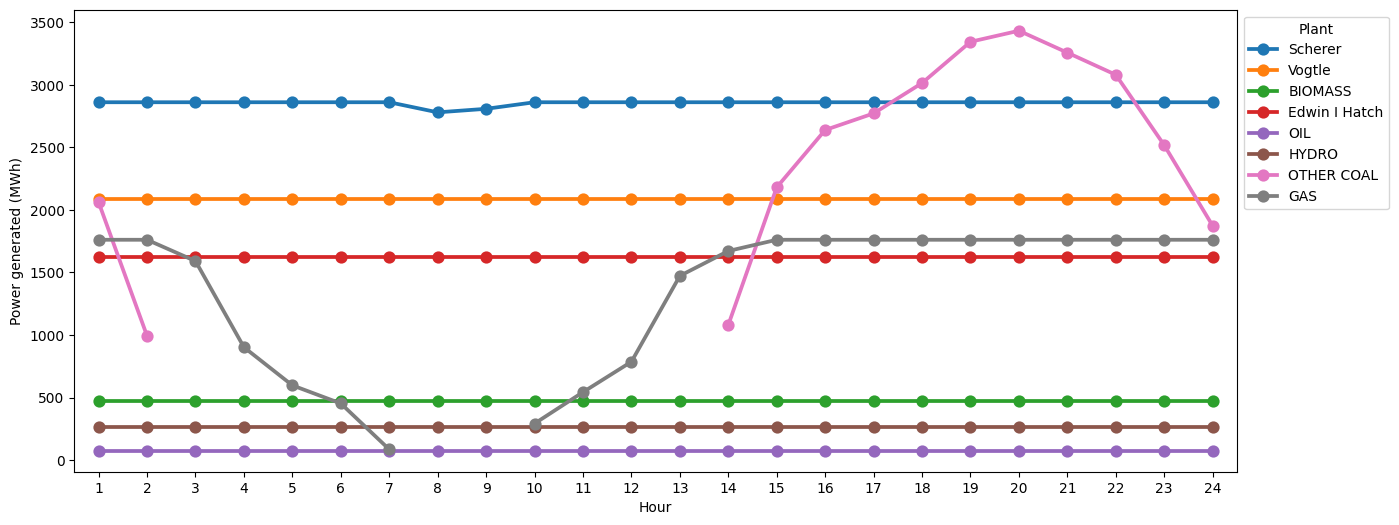

Power demand:


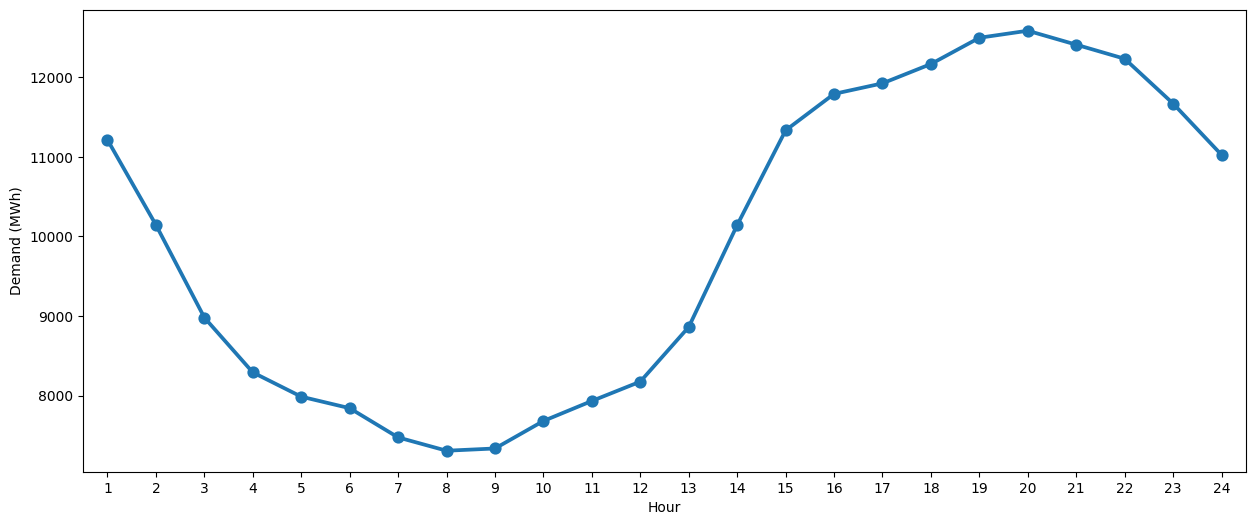

In [59]:
solution = pd.DataFrame() 
solution = pd.DataFrame(columns=['Hour', 'Power (MWh)', 'Plant']) 
plant_hour_pairs = [(h,i) for i in P for h in H  if z[i,h].X > 0] 
            
solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1],pair[0]].X for pair in plant_hour_pairs]
            
print("Power supply:")
fig, ax = plt.subplots(figsize=(15,6)) 
sns.pointplot(data=solution,x='Hour', y='Power generated (MWh)', hue='Plant')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

print("Power demand:")
fig, ax = plt.subplots(figsize=(15,6)) 
demand = pd.DataFrame(columns=['Hour', 'Demand (MWh)']) 
demand['Hour'] = list(H)
demand['Demand (MWh)'] = [d[h] for h in H]
sns.pointplot(data=demand,x='Hour', y='Demand (MWh)')
plt.show() 


最具成本效益的发电调度主要从煤电厂Scherer和核电厂Vogtle和Edwin I Hatch中获取电力。

为了匹配24小时内电力需求的波动,我们看到一些发电厂的发电量波动。
大部分波动由"其他煤电厂"承担; 一个特别极端的情况是,它在第2小时关闭,在第14小时重新启动。
我们在天然气发电厂中也看到了类似的波动。

### 最优成本

以下是此最优发电调度产生的成本分解。如预期的那样,燃料成本和健康成本是总成本的主要贡献者。

In [60]:
print("Fuel costs: $",round(sum(f[i]*z[i,h].X for i in P for h in H)*10**(-6),2),"million")
print("Health costs: $",round(sum(a[i,h]*z[i,h].X for i in P for h in H)*10**(-6),2),"million")
print("Operating costs: $",round(sum(o[i]*u[i,h].X for i in P for h in H),2))
print("Start-up costs: $",round(sum(s[i]*v[i,h].X for i in P for h in H),2))
print("Start-up costs: $",round(sum(s[i]*w[i,h].X for i in P for h in H),2))

Fuel costs: $ 4.29 million
Health costs: $ 0.2 million
Operating costs: $ 1622.73
Start-up costs: $ 219.0
Start-up costs: $ 219.0


### 可视化二进制变量

我们注意到"其他煤电厂"在某个时刻被关闭,并在稍后重新启动。我们可以可视化开/关二进制变量如何捕捉这种情况。

In [61]:
sol = pd.DataFrame()
plant = 'OTHER COAL'
sol['hour'] = [h for h in H]
sol['v[i,h]'] = [v[plant,h].X for h in H]
sol['w[i,h]'] = [w[plant,h].X for h in H]
sol['u[i,h]'] = [u[plant,h].X for h in H] 
sol['z[i,h]'] = [z[plant,h].X for h in H] 
sol

,hour,"v[i,h]","w[i,h]","u[i,h]","z[i,h]"
0,1,0.0,0.0,1.0,2060.91224
1,2,0.0,0.0,1.0,993.05342
2,3,0.0,1.0,0.0,0.00000
3,4,0.0,-0.0,0.0,0.00000
4,5,0.0,-0.0,0.0,0.00000
5,6,0.0,-0.0,0.0,0.00000
6,7,0.0,-0.0,0.0,0.00000
7,8,0.0,-0.0,-0.0,0.00000
8,9,0.0,-0.0,-0.0,0.00000
9,10,0.0,-0.0,-0.0,0.00000


## 完整模型

以下是构建和解决优化模型的完整代码。

In [62]:
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("powergeneration")

# 定义变量
z = model.addVars(P,H,name="z", lb=0) # 每个发电厂每小时产生的电力
u = model.addVars(P,H,name="u", vtype=GRB.BINARY, lb=0) # 发电厂是否开启? 每个发电厂每小时
v = model.addVars(P,H,name="v", vtype=GRB.BINARY) # 启动发电厂? 每个发电厂每小时
w = model.addVars(P,H,name="w", vtype=GRB.BINARY) # 关闭发电厂? 每个发电厂每小时

# 通过添加所有成本设置目标函数
objective = gp.quicksum(f[i]*z[i,h] for i in P for h in H) # 燃料成本
objective += gp.quicksum(a[i,h]*z[i,h] for i in P for h in H) # 健康成本
objective += gp.quicksum(o[i]*u[i,h] for i in P for h in H) # 运营成本
objective += gp.quicksum(s[i]*v[i,h] for i in P for h in H) # 启动成本
objective += gp.quicksum(t[i]*w[i,h] for i in P for h in H) # 关闭成本
model.setObjective(objective,sense=GRB.MINIMIZE)

# 设置满足需求的约束
model.addConstrs((gp.quicksum(z[i,h] for i in P) == d[h]) for h in H)  

# 设置最小和最大发电限制的约束
model.addConstrs((z[i,h] >= m[i]*c[i]*u[i,h]) for i in P for h in H)  
model.addConstrs((z[i,h] <= c[i]*u[i,h]) for i in P for h in H)  

# 设置保持核电厂始终开启的约束
model.addConstrs((z[i,h] >= m[i]*c[i]) for i in P_N for h in H)   

# 设置确保爬坡和降坡速度在限制范围内的约束
model.addConstrs((z[i,h]-z[i,h-1] >= -r[i]*c[i]) for i in P for h in H if h>1)  
model.addConstrs((z[i,h]-z[i,h-1] <= r[i]*c[i]) for i in P for h in H if h>1)  

# 设置确保发电厂开启时应该开启的约束
model.addConstrs((v[i,h] <= u[i,h]) for i in P for h in H)  

# 设置确保发电厂关闭时应该关闭的约束
model.addConstrs((w[i,h] <= 1-u[i,h]) for i in P for h in H)  

# 设置将启动/关闭变量(v,w)与开/关变量(u)链接的约束
model.addConstrs((v[i,h] - w[i,h] == u[i,h] - u[i,h-1]) for i in P for h in H if h > 1) 

# 求解模型
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 1722 rows, 960 columns and 4048 nonzeros
Model fingerprint: 0x3e7bcb3f
Variable types: 240 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+03]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 982 rows and 400 columns
Presolve time: 0.01s
Presolved: 740 rows, 560 columns, 2044 nonzeros
Variable types: 216 continuous, 344 integer (344 binary)
Found heuristic solution: objective 5286841.8503
Found heuristic solution: objective 4732800.2024

Root relaxation: objective 4.495125e+06, 183 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

版权所有 © 2023 Gurobi Optimization, LLC